# Impact of 3.2 Beer in Kansas

In [1]:
# packages used
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

### Load Data

In [2]:
Stores = pd.read_csv('MinnesotaStoreDataV1.csv')

#### Clean Data

In [3]:
#Remove Stores without Depletion data for the last year (NAs)
Stores = Stores.loc[Stores['L12M_TY_QTY'].notnull(),:]

#Remove Stores with Negative Depletion data for the last year
Stores = Stores.loc[Stores['L12M_TY_QTY'] >= 0,:] 

#Remove Stores without Demographic data (NAs)
Stores = Stores.loc[Stores['MALE_POP_5564_PCT'].notnull(),:] 

Stores = Stores.reset_index(drop=True)

#Change Y and N to 1 and 0
Stores['CHAIN_IND_FLG'] = Stores['CHAIN_IND_FLG']=='Y'
Stores['FRANCHISE_FLG'] = Stores['FRANCHISE_FLG']=='Y'
Stores['BEER_FLG'] = Stores['BEER_FLG']=='Y'
Stores['WINE_FLG'] = Stores['WINE_FLG']=='Y'
Stores['LIQUOR_FLG'] = Stores['LIQUOR_FLG']=='Y'
Stores['FINE_WINE_FLG'] = Stores['FINE_WINE_FLG']=='Y'

Stores['STORE_CD'] = Stores['STORE_CD'].astype(str)

In [4]:
Stores.head()

,STORE_CD,L12M_TY_QTY,PREMISE_TYPE_DSC,CHANNEL_DSC,SUBCHANNEL_DSC,NO_OF_STORES_DSC,FOOD_TYPE_GROUP_DSC,INDUSTRY_VOL_DSC,PATRON_ETHNICITY_DSC,PATRON_OCCUPATION_DSC,...,MALE_POP_5564_PCT,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT
0,103793493,397.8332,ON PREMISE,DINING,CASUAL DINING,1 STORE,MEXICAN,MID 30% ON/ MID 60% OFF,GENERAL POPULATION,UNKNOWN,...,0.0581,0.0354,0.0216,0.0201,0.1052,0.0728,0.0595,0.0599,0.0413,0.0334
1,103779046,0.0000,OFF PREMISE,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,1 STORE,OTHER,LOWEST 20% ON/ LOWEST 20% OFF,GENERAL POPULATION,UNKNOWN,...,0.0483,0.0305,0.0135,0.0589,0.1088,0.0667,0.0420,0.0450,0.0310,0.0185
2,105646503,13.0000,ON PREMISE,BAR/NIGHTCLUB,CASUAL NIGHTCLUB,1 STORE,OTHER,TOP 50% ON/ TOP 20% OFF,GENERAL POPULATION,UNKNOWN,...,0.0658,0.0376,0.0240,0.0230,0.0546,0.0669,0.0703,0.0619,0.0402,0.0338
3,105645328,6.0000,ON PREMISE,DINING,CASUAL DINING,1 STORE,VARIED MENU,LOWEST 20% ON/ LOWEST 20% OFF,GENERAL POPULATION,UNKNOWN,...,0.0905,0.1062,0.0501,0.0184,0.0411,0.0345,0.0530,0.0845,0.1039,0.0463
4,202252793,330.8054,ON PREMISE,DINING,CASUAL DINING,1 STORE,MEXICAN,LOWEST 20% ON/ LOWEST 20% OFF,GENERAL POPULATION,UNKNOWN,...,0.0629,0.0455,0.0313,0.0239,0.0597,0.0594,0.0636,0.0676,0.0530,0.0532


In [5]:
#Number of Stores
len(Stores)

5869

### Data Preprocessing

In [6]:
#Binarize function
def binarize(dataframe , column):
    dataframe = pd.concat([dataframe ,pd.get_dummies(dataframe[column] , prefix = ['B_'+c for c in column])] , axis = 1)
    return(dataframe)

In [7]:
#Get Dummies
DummiesColumns = ['PREMISE_TYPE_DSC','CHANNEL_DSC','SUBCHANNEL_DSC','NO_OF_STORES_DSC','FOOD_TYPE_GROUP_DSC','INDUSTRY_VOL_DSC',
                 'PATRON_ETHNICITY_DSC','PATRON_OCCUPATION_DSC','PATRON_AGE_DSC']
StoresC = binarize(Stores, DummiesColumns)

In [8]:
# prepare data to fit model
X_labels = [c for c in StoresC.columns if c not in ['PREMISE_TYPE_DSC','CHANNEL_DSC','SUBCHANNEL_DSC','NO_OF_STORES_DSC',
                                                     'FOOD_TYPE_GROUP_DSC','INDUSTRY_VOL_DSC','PATRON_ETHNICITY_DSC',
                                                     'PATRON_OCCUPATION_DSC','PATRON_AGE_DSC','STORE_CD']]
X = StoresC.loc[:,X_labels]

In [9]:
X.head()

,L12M_TY_QTY,CHAIN_IND_FLG,FRANCHISE_FLG,BEER_FLG,WINE_FLG,LIQUOR_FLG,FINE_WINE_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,...,B_PATRON_ETHNICITY_DSC_MEXICAN,B_PATRON_ETHNICITY_DSC_UNKNOWN,B_PATRON_OCCUPATION_DSC_BLUE COLLAR,B_PATRON_OCCUPATION_DSC_COLLEGE,B_PATRON_OCCUPATION_DSC_OTHER,B_PATRON_OCCUPATION_DSC_UNKNOWN,B_PATRON_OCCUPATION_DSC_WHITE COLLAR,B_PATRON_AGE_DSC_GENERAL POPULATION,B_PATRON_AGE_DSC_UNKNOWN,B_PATRON_AGE_DSC_YOUNG ADULT (21-28)
0,397.8332,False,False,True,True,True,False,0.7596,0.1108,0.0554,...,0,0,0,0,0,1,0,1,0,0
1,0.0000,False,False,True,False,False,False,0.7084,0.1061,0.0810,...,0,0,0,0,0,1,0,1,0,0
2,13.0000,False,False,True,True,True,False,0.9312,0.0072,0.0114,...,0,0,0,0,0,1,0,1,0,0
3,6.0000,False,False,True,True,True,False,0.7775,0.0035,0.0019,...,0,0,0,0,0,1,0,1,0,0
4,330.8054,False,False,True,True,True,False,0.9530,0.0062,0.0091,...,0,0,0,0,0,1,0,1,0,0


## Clustering

### Choose number of Clusters

In [10]:
#Elbow Method
K = range(1, 100)
meandistortions = []
for k in K:
    kmeans = KMeans(n_clusters=k, n_jobs = -2)
    kmeans.fit(X)
    meandistortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

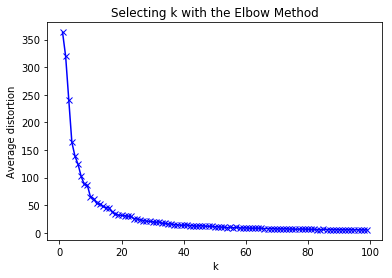

In [11]:
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()

In [12]:
#Tunned Elbow Method
K = range(1, 20)
meandistortions = []
for k in K:
    kmeans = KMeans(n_clusters=k, n_jobs = -2)
    kmeans.fit(X)
    meandistortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

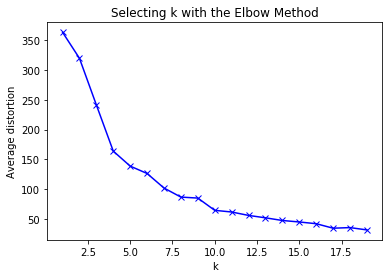

In [13]:
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()

In [16]:
#Silhouette_score
#results = []
#NumberClusters = range(2,15,1)
#for k in NumberClusters:
#    kmeans_model = cluster.KMeans(n_clusters=k, random_state=1, n_jobs = -2).fit(X)
#    labels = kmeans_model.labels_
#    score = metrics.silhouette_score(X, labels, metric='euclidean')
#    results.append((k,score))

#Clustering_Score = pd.DataFrame(data=results,columns=['NumberOfClusters','silhouette_score'])
#Clustering_Score

In [17]:
#Cluster the Data
kmeans_model = cluster.KMeans(n_clusters=10, random_state=1, n_jobs = -2).fit(X)
labels = kmeans_model.labels_

In [18]:
#Assign Cluster to Data
Stores['CLUSTER'] = labels

## Regression Analysis

In [20]:
#Load classification data
StoresClass = pd.read_csv('NonLowPointStoresMinnesota.csv', dtype = str)

In [21]:
StoresClass.head()

,RTL_STORE_CD,BEERTYPE
0,101857377,NonLowPoint
1,107046430,NonLowPoint
2,101971024,NonLowPoint
3,102194556,NonLowPoint
4,205647194,NonLowPoint


In [22]:
#Merge Class with Store Data for regression
RegressionData = pd.merge(Stores, StoresClass, left_on='STORE_CD', right_on="RTL_STORE_CD", how="left")
RegressionData.loc[RegressionData['BEERTYPE'].isnull(),"BEERTYPE"] = "LowPoint"

In [23]:
RegressionData.head()

,STORE_CD,L12M_TY_QTY,PREMISE_TYPE_DSC,CHANNEL_DSC,SUBCHANNEL_DSC,NO_OF_STORES_DSC,FOOD_TYPE_GROUP_DSC,INDUSTRY_VOL_DSC,PATRON_ETHNICITY_DSC,PATRON_OCCUPATION_DSC,...,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,CLUSTER,RTL_STORE_CD,BEERTYPE
0,103793493,397.8332,ON PREMISE,DINING,CASUAL DINING,1 STORE,MEXICAN,MID 30% ON/ MID 60% OFF,GENERAL POPULATION,UNKNOWN,...,0.0201,0.1052,0.0728,0.0595,0.0599,0.0413,0.0334,5,103793493,NonLowPoint
1,103779046,0.0000,OFF PREMISE,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,1 STORE,OTHER,LOWEST 20% ON/ LOWEST 20% OFF,GENERAL POPULATION,UNKNOWN,...,0.0589,0.1088,0.0667,0.0420,0.0450,0.0310,0.0185,0,NaN,LowPoint
2,105646503,13.0000,ON PREMISE,BAR/NIGHTCLUB,CASUAL NIGHTCLUB,1 STORE,OTHER,TOP 50% ON/ TOP 20% OFF,GENERAL POPULATION,UNKNOWN,...,0.0230,0.0546,0.0669,0.0703,0.0619,0.0402,0.0338,0,105646503,NonLowPoint
3,105645328,6.0000,ON PREMISE,DINING,CASUAL DINING,1 STORE,VARIED MENU,LOWEST 20% ON/ LOWEST 20% OFF,GENERAL POPULATION,UNKNOWN,...,0.0184,0.0411,0.0345,0.0530,0.0845,0.1039,0.0463,0,105645328,NonLowPoint
4,202252793,330.8054,ON PREMISE,DINING,CASUAL DINING,1 STORE,MEXICAN,LOWEST 20% ON/ LOWEST 20% OFF,GENERAL POPULATION,UNKNOWN,...,0.0239,0.0597,0.0594,0.0636,0.0676,0.0530,0.0532,5,202252793,NonLowPoint


In [24]:
len(RegressionData)

5869

### Regression controlling for Cluster

In [25]:
mod = smf.ols(formula='L12M_TY_QTY ~ C(BEERTYPE) + C(PREMISE_TYPE_DSC) + C(CLUSTER)', data=RegressionData)

In [26]:
print(mod.fit().summary())

                            OLS Regression Results                            
Dep. Variable:            L12M_TY_QTY   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 3.194e+04
Date:                Tue, 27 Jun 2017   Prob (F-statistic):               0.00
Time:                        14:29:00   Log-Likelihood:                -37489.
No. Observations:                5869   AIC:                         7.500e+04
Df Residuals:                    5857   BIC:                         7.508e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc